In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sat Jan 27 18:43:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999
hp.noise = 1e-2
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.27-7/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 8596
-rw-rw-r-- 1 scpark scpark 1315412  1월 27 18:43 events.out.tfevents.1706347721.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7471539  1월 27 18:28 save_0
-rw-rw-r-- 1 scpark scpark      40  1월 27 18:28 events.out.tfevents.1706347689.GPUSVR11


In [7]:
# path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
# checkpoint = torch.load(path, map_location=torch.device('cpu'))
# # warm start
# for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
#     model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
# print('done')

### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

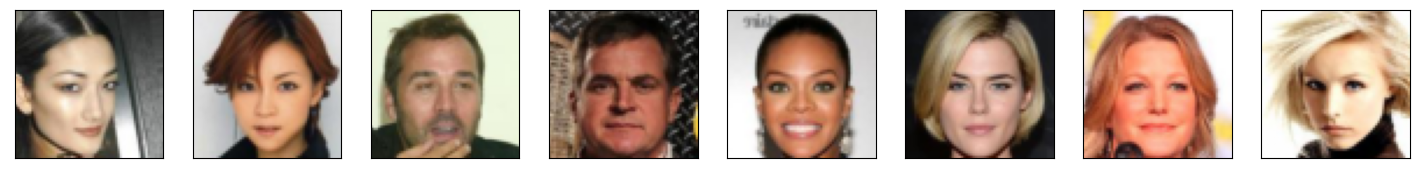

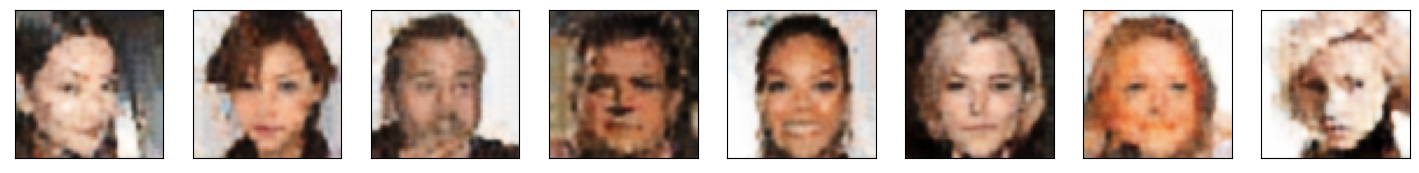

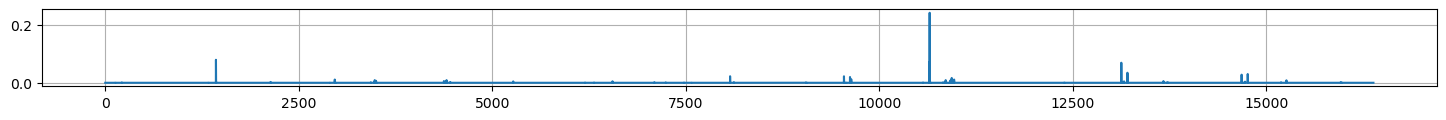

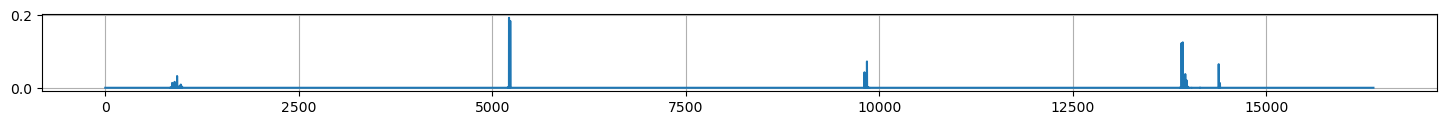

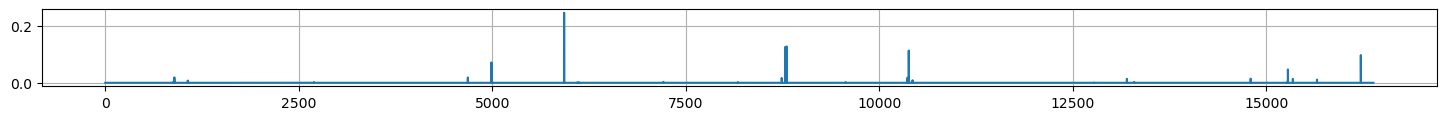

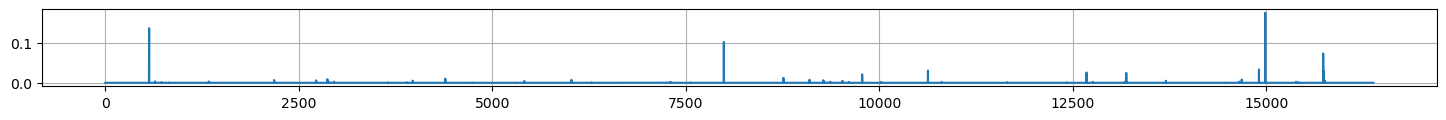

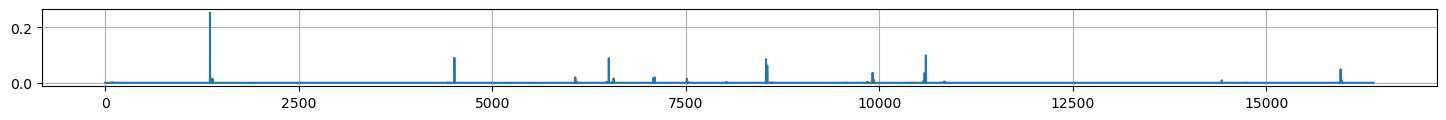

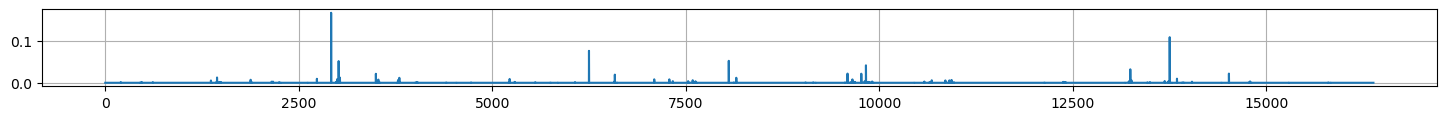

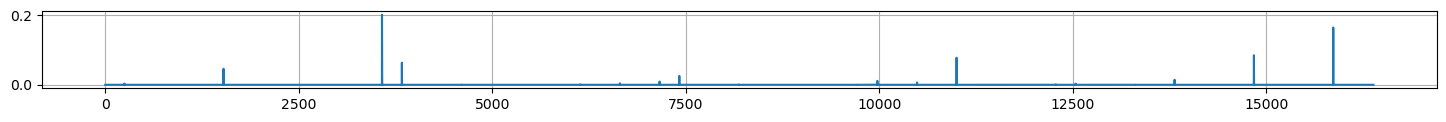

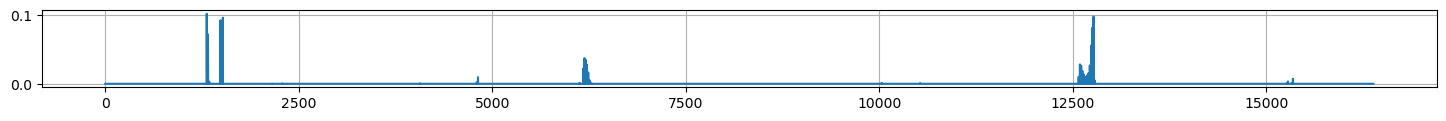

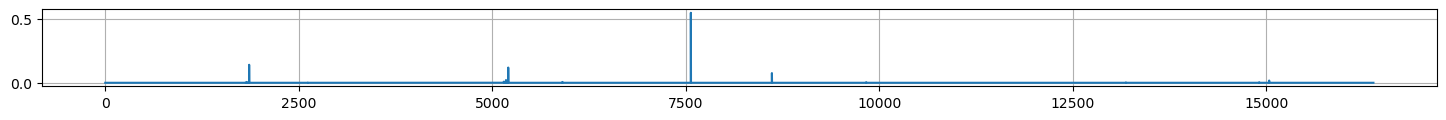

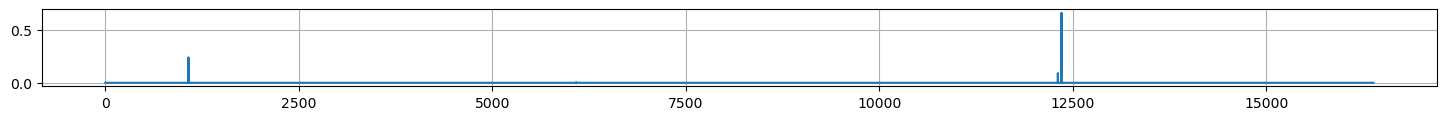

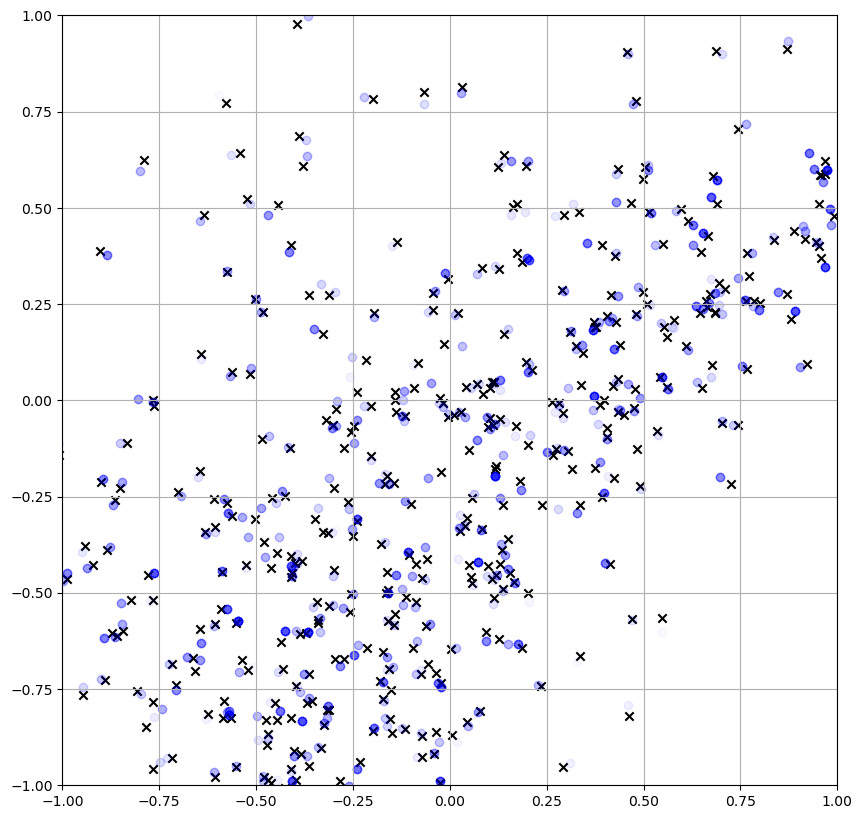

22001
lse_loss -160.1006622314453
commit_loss 0.0038511818274855614
recon_loss 0.0006142441416159272
22002
lse_loss -160.1104736328125
commit_loss 0.004233171232044697
recon_loss 0.0006243879906833172
22003
lse_loss -159.9974822998047
commit_loss 0.00390478502959013
recon_loss 0.0005896790535189211
22004
lse_loss -159.8564453125
commit_loss 0.0039748260751366615
recon_loss 0.0005590517539530993
22005
lse_loss -159.69113159179688
commit_loss 0.005059490911662579
recon_loss 0.000712080392986536
22006
lse_loss -160.0167999267578
commit_loss 0.004062802065163851
recon_loss 0.0007281424477696419
22007
lse_loss -160.11862182617188
commit_loss 0.004032926168292761
recon_loss 0.0006224080570973456
22008
lse_loss -160.012939453125
commit_loss 0.004216612316668034
recon_loss 0.0005979245761409402
22009
lse_loss -160.0970001220703
commit_loss 0.0037313569337129593
recon_loss 0.00061102892505005
22010
lse_loss -159.75616455078125
commit_loss 0.0042252494022250175
recon_loss 0.0005645225173793733
2

22083
lse_loss -160.07273864746094
commit_loss 0.004947507753968239
recon_loss 0.0007990450831130147
22084
lse_loss -160.34164428710938
commit_loss 0.004478740505874157
recon_loss 0.000700484961271286
22085
lse_loss -160.15699768066406
commit_loss 0.004167875740677118
recon_loss 0.000632306735496968
22086
lse_loss -160.64639282226562
commit_loss 0.004420357756316662
recon_loss 0.0006860740249976516
22087
lse_loss -160.4703369140625
commit_loss 0.0038294673431664705
recon_loss 0.0007755872793495655
22088
lse_loss -159.99803161621094
commit_loss 0.004728391766548157
recon_loss 0.0006423862650990486
22089
lse_loss -160.61343383789062
commit_loss 0.004053699318319559
recon_loss 0.0007653282955288887
22090
lse_loss -160.45814514160156
commit_loss 0.004466413054615259
recon_loss 0.0005864244303666055
22091
lse_loss -160.22802734375
commit_loss 0.004317798651754856
recon_loss 0.0007094355532899499
22092
lse_loss -160.34332275390625
commit_loss 0.0043950919061899185
recon_loss 0.00064975337591

22165
lse_loss -160.80125427246094
commit_loss 0.004205907694995403
recon_loss 0.0006170629058033228
22166
lse_loss -161.01788330078125
commit_loss 0.003923870623111725
recon_loss 0.0005797857884317636
22167
lse_loss -160.920654296875
commit_loss 0.003969014622271061
recon_loss 0.0007342075696215034
22168
lse_loss -160.9954071044922
commit_loss 0.0038714096881449223
recon_loss 0.0006469491636380553
22169
lse_loss -160.92010498046875
commit_loss 0.003716391744092107
recon_loss 0.0006254427134990692
22170
lse_loss -160.88047790527344
commit_loss 0.00440861564129591
recon_loss 0.000823191599920392
22171
lse_loss -160.6824188232422
commit_loss 0.0044249240309000015
recon_loss 0.0009474758990108967
22172
lse_loss -160.9402618408203
commit_loss 0.004017731174826622
recon_loss 0.0005643335753120482
22173
lse_loss -160.5139617919922
commit_loss 0.004037773702293634
recon_loss 0.0007386963116005063
22174
lse_loss -160.29856872558594
commit_loss 0.004467172548174858
recon_loss 0.0007384037016890

22247
lse_loss -161.62281799316406
commit_loss 0.004057887010276318
recon_loss 0.0006359019316732883
22248
lse_loss -161.59426879882812
commit_loss 0.003884454257786274
recon_loss 0.0005792329902760684
22249
lse_loss -161.5429229736328
commit_loss 0.003813511459156871
recon_loss 0.0006435583345592022
22250
lse_loss -161.5622100830078
commit_loss 0.00414205901324749
recon_loss 0.0006104626227170229
22251
lse_loss -161.48019409179688
commit_loss 0.004275820218026638
recon_loss 0.0006309120217338204
22252
lse_loss -161.40550231933594
commit_loss 0.0039520831778645515
recon_loss 0.0006068323273211718
22253
lse_loss -161.27333068847656
commit_loss 0.0038512737955898046
recon_loss 0.0005599946016445756
22254
lse_loss -161.63816833496094
commit_loss 0.003838588483631611
recon_loss 0.0005144317401573062
22255
lse_loss -161.58917236328125
commit_loss 0.003762498963624239
recon_loss 0.0005991935613565147
22256
lse_loss -161.54844665527344
commit_loss 0.003967775963246822
recon_loss 0.00069596117

lse_loss -161.8803253173828
commit_loss 0.0037216502241790295
recon_loss 0.0005869134329259396
22330
lse_loss -161.73255920410156
commit_loss 0.003622910939157009
recon_loss 0.0007102891686372459
22331
lse_loss -162.24803161621094
commit_loss 0.0033601047471165657
recon_loss 0.0005505200242623687
22332
lse_loss -161.968505859375
commit_loss 0.0038685789331793785
recon_loss 0.0006234004395082593
22333
lse_loss -162.20201110839844
commit_loss 0.004076986573636532
recon_loss 0.0006498449947685003
22334
lse_loss -161.9311981201172
commit_loss 0.003961819224059582
recon_loss 0.0006020172731950879
22335
lse_loss -162.01075744628906
commit_loss 0.0038684119936078787
recon_loss 0.0006209257990121841
22336
lse_loss -161.87899780273438
commit_loss 0.004066298250108957
recon_loss 0.000581985164899379
22337
lse_loss -161.9935760498047
commit_loss 0.003973234910517931
recon_loss 0.0007029451662674546
22338
lse_loss -162.04684448242188
commit_loss 0.0037359721027314663
recon_loss 0.00057557405671104

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)
            
            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 100 == 0:
            loss_dict = {}
            for model in model_list:
                data = preprocess(batch)
                
                # Forward
                model.eval()
                with torch.no_grad():
                    data = model(data, latent_temp=1, quantize=True)

                for key in data.keys():
                    if 'loss' in key:
                        if key in loss_dict:
                            loss_dict[key].append(data[key].item())
                        else:
                            loss_dict[key] = [data[key].item()]
                        
            writer.add_scalar('eval_recon_loss', np.mean(loss_dict['recon_loss']), step)
            
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')